In [1]:
#import functions
import numpy as np
from numpy import linalg

import cv2 as cv
import scipy
from scipy import signal

import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl

import os
import shutil

from utils import resize_percent, edge_detect, count_gray_levels, fill

In [2]:
#cross correlation function

def cross_correlation (frNum, path_to_images, pixel, kernel, x_disp=False, y_disp=False):
    image_1_name = os.fsdecode(os.listdir(path_to_images)[0])
    image_1 = cv.imread(path_to_images + f'{image_1_name}', cv.IMREAD_GRAYSCALE)
    corr_full_x = np.zeros([image_1.shape[1], frNum])
    corr_full_y = np.zeros([image_1.shape[0], frNum])
    k=0
    while k<frNum:
        image_name = str(k) + '.jpg'
        image_next = cv.imread(path_to_images+f'{image_name}', cv.IMREAD_GRAYSCALE)
        if x_disp:
            arr_1 = np.ones([kernel,]) * image_1[pixel[0], pixel[1]]
            corr = signal.correlate(image_next[pixel[0], :], arr_1, mode='same')
            corr = np.reshape(cv.normalize(corr, None, 1, 256, cv.NORM_MINMAX), (image_1.shape[1],)) #normalization added
            corr_full_x[:, k] = corr
        if y_disp:
            arr_1 = np.ones([kernel,]) * image_1[pixel[0], pixel[1]]
            corr = signal.correlate(image_next[:, pixel[1]], np.transpose(arr_1), mode='same')
            corr = np.reshape(cv.normalize(corr, None, 1, 256, cv.NORM_MINMAX), (image_1.shape[0],)) #normalization added
            corr_full_y[:, k] = corr          
        k+=1
    
    return corr_full_x, corr_full_y

In [3]:
'''Cropping the images''' 

'- data_path: path to the folder with the images to crop'
'- data_save: path to the folder to save the cropped images'
'- x_start: a starting x coordinate to crop an image'
'- x_end: an ending x coordinate to crop an image'
'- y_start: a starting y coordinate to crop an image'
'- y_end: an ending y coordinate to crop an image'
'- color: indicate if the images to crop are colored'

def crop_images(data_path, data_save, x_start, x_end, y_start, y_end, color=False):
    for image in os.listdir(data_path):
        image_name = os.fsdecode(image)
        if color:
            img_next = cv.imread(data_path+f'{image_name}', cv.IMREAD_COLOR)
            cropped_img = img_next[x_start : x_end, y_start : y_end, :]
            cv.imwrite(data_save + f'{image_name}', cropped_img)
        else:
            img_next = cv.imread(data_path+f'{image_name}', cv.IMREAD_GRAYSCALE)
            cropped_img = img_next[x_start : x_end, y_start : y_end]
            cv.imwrite(data_save + f'{image_name}', cropped_img)

In [ ]:
#ONLY RUN ONCE
#making folders
os.mkdir('sim_G1100')
os.mkdir('sim_G1100_crop')

In [ ]:
# #ONLY RUN ONCE
# #extracting frames from the simulated 2 percent G1100 video
# video_name = 'test2percent_G1100_cut'
# path_to_source = 'data/' + video_name + '.avi'
# cap = cv.VideoCapture(path_to_source)
# num_frames = 50
# l=0
# m=0
# while l <= num_frames:
#     ret, frame = cap.read()
#     if not ret: 
#         print('No frames grabbed!')
#         break
#     cv.imwrite(f'sim_G1100/{m}.jpg', frame)
#     l+=1
#     m+=1

In [ ]:
# #ONLY RUN ONCE
# # crop images for faster calculation 
# data_path = 'sim_G1100/'
# data_save = 'sim_G1100_crop/'
# x_start = 0
# x_end = 100
# y_start = 0
# y_end = 100
# crop_images(data_path, data_save, x_start, x_end, y_start, y_end, color=False)

In [4]:
# thresholding the cross correlation image
def thresh_xcorr (image, T):
    image[image<T] = 0
    image[image>T] = 1
    return image

In [5]:
def apply_blurring(img, kernel_size, sigma_x):
    return cv.GaussianBlur(src=img.copy(), ksize=(kernel_size, kernel_size), sigmaX=sigma_x)

In [6]:
def apply_in_range_threshold(img, lower_bound, upper_bound):
    return cv.inRange(src=img.copy(), lowerb=lower_bound, upperb=upper_bound)

In [7]:
# method1 to calculate the slope with a line fit
slope = 3
def slope_detect(T, frNum, path_to_images, pixel, kernel):
    global angle
    _, corr_full_y = cross_correlation(frNum, path_to_images, pixel, kernel, x_disp=False, y_disp=True)
    image_xcorr = np.copy(corr_full_y)
    image = thresh_xcorr (image_xcorr, T)
    zero_coords = np.argwhere(image==0)
    slope, b = np.polyfit(zero_coords[:,1], zero_coords[:,0], 1)
    if slope<0:
        zero_coords = np.argwhere(image==1)
        slope, b = np.polyfit(zero_coords[:,1], zero_coords[:,0], 1)
    else:
        slope = slope
    return slope

In [8]:
#method2 to calculate the slope with a pixel assignment
slope = 3
def slope_detect(T, frNum, path_to_images, pixel, kernel):
    global angle
    _, corr_full_y = cross_correlation(frNum, path_to_images, pixel, kernel, x_disp=False, y_disp=True)
    image_xcorr = np.copy(corr_full_y)
    image = thresh_xcorr (image_xcorr, T)
    non0_firstCol = np.argwhere(image[:,0]==1)
    zero_lastCol = np.argwhere(image[:,-1]==0)
    slope = (zero_lastCol[-1] - non0_firstCol[0])/frNum
    return slope

In [9]:
# to check the size of the processed frames
path_to_images = 'sim_G1100_crop/'
image_1 = cv.imread(path_to_images + '0.jpg', cv.IMREAD_GRAYSCALE)
height = image_1.shape[0]
width = image_1.shape[1]

print("x: ", width)
print("y: ",height)

x:  50
y:  100


In [27]:
frNum = 10
path_to_images = 'sim_G1100_crop/'

kernel = 1
threshold_bin = 0
image_1 = cv.imread(path_to_images + '0.jpg', cv.IMREAD_GRAYSCALE)
slopes = np.zeros([image_1.shape[0], image_1.shape[1]])  # empty matrix of 100x100

# T = 200 #2 percent
T = 20
for i in range(image_1.shape[0]):
    for j in range(image_1.shape[1]):
        pixel=[i, j]
        try:
            slope = slope_detect(T, frNum, path_to_images, pixel, kernel)
        except ValueError:
            slope = None
        slopes[i, j] = slope
        print(pixel, slope)

[0, 0] [2.5]
[0, 1] [2.5]
[0, 2] [2.5]
[0, 3] [2.5]
[0, 4] [2.5]
[0, 5] [2.5]
[0, 6] [2.5]
[0, 7] [2.6]
[0, 8] [2.5]
[0, 9] [2.5]
[0, 10] [2.5]
[0, 11] [2.5]
[0, 12] [2.5]
[0, 13] [2.5]
[0, 14] [2.5]
[0, 15] [2.6]
[0, 16] [2.5]
[0, 17] [2.5]
[0, 18] [2.5]
[0, 19] [2.6]
[0, 20] [2.6]
[0, 21] [2.5]
[0, 22] [2.5]
[0, 23] [2.5]
[0, 24] [2.4]
[0, 25] [2.4]
[0, 26] [2.4]
[0, 27] [2.4]
[0, 28] [2.5]
[0, 29] [2.4]
[0, 30] [2.4]
[0, 31] [2.4]
[0, 32] [2.4]
[0, 33] [2.4]
[0, 34] [2.4]
[0, 35] [2.4]
[0, 36] [2.3]
[0, 37] [2.4]
[0, 38] [2.4]
[0, 39] [2.4]
[0, 40] [2.3]
[0, 41] [2.3]
[0, 42] [2.4]
[0, 43] [2.1]
[0, 44] [2.3]
[0, 45] [2.4]
[0, 46] [2.4]
[0, 47] [2.3]
[0, 48] [2.2]
[0, 49] [2.2]
[1, 0] [2.5]
[1, 1] [2.5]
[1, 2] [2.5]
[1, 3] [2.5]
[1, 4] [2.5]
[1, 5] [2.5]
[1, 6] [2.5]
[1, 7] [2.6]
[1, 8] [2.5]
[1, 9] [2.5]
[1, 10] [2.5]
[1, 11] [2.5]
[1, 12] [2.5]
[1, 13] [2.5]
[1, 14] [2.5]
[1, 15] [2.6]
[1, 16] [2.5]
[1, 17] [2.5]
[1, 18] [2.5]
[1, 19] [2.6]
[1, 20] [2.6]
[1, 21] [2.5]
[1, 22] [2.5

In [28]:
print(slopes[80,20])

2.6


In [12]:
# saving the array to not run the same thing again
slope_folder = 'comsol_calculated_slopes/'
video_name = 'sim_G1100_lineFit'
np.savetxt(slope_folder+video_name+'.csv', slopes, delimiter=",")

In [ ]:
# loading the saved array back
with open(slope_folder+video_name+'.csv') as file_name:
    array = np.loadtxt(file_name, delimiter=",")

print(array)
print(type(array))

In [83]:
m = np.mean(slopes)
stdv = np.std(slopes)
med = np.median(slopes)
vari = np.var(slopes)

print('mean is: ', m , 'stdv is: ', stdv, 'median is: ', med, 'variance is: ', vari )

mean is:  2.434 stdv is:  0.10316976301223146 median is:  2.45 variance is:  0.010644000000000004


[[2.5 2.5 2.5 ... 2.3 2.2 2.2]
 [2.5 2.5 2.5 ... 2.3 2.2 2.2]
 [2.5 2.5 2.5 ... 2.3 2.2 2.2]
 ...
 [2.5 2.5 2.5 ... 2.3 2.2 2.2]
 [2.5 2.5 2.5 ... 2.3 2.2 2.2]
 [2.5 2.5 2.5 ... 2.3 2.2 2.2]]


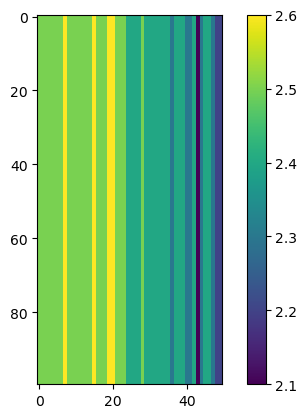

In [29]:
print(slopes)
plt.imshow(slopes)
plt.colorbar()
plt.savefig('comsol_G1100_speed_pxfr.png')

[[0.72900467 0.72900467 0.72900467 ... 0.67068429 0.64152411 0.64152411]
 [0.72900467 0.72900467 0.72900467 ... 0.67068429 0.64152411 0.64152411]
 [0.72900467 0.72900467 0.72900467 ... 0.67068429 0.64152411 0.64152411]
 ...
 [0.72900467 0.72900467 0.72900467 ... 0.67068429 0.64152411 0.64152411]
 [0.72900467 0.72900467 0.72900467 ... 0.67068429 0.64152411 0.64152411]
 [0.72900467 0.72900467 0.72900467 ... 0.67068429 0.64152411 0.64152411]]


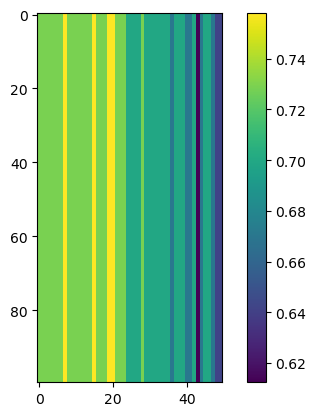

In [77]:
conv_pix = (1/1.286)*1e-6
conv_fr = (1/12500)/3/10 #(12500*85)/(85/10)
slopes_SI = slopes * (conv_pix / conv_fr)
print(slopes_SI)
plt.imshow(slopes_SI)
plt.colorbar()
plt.savefig('comsol_G1100_speed_SI.png')


In [41]:
arr = np.argwhere(np.isnan(slopes))
print(arr)

[]


In [16]:
arr = np.argwhere(np.round(slopes,1)==0.5)
print(arr)

[]


[[2.5 2.5 2.5 ... 2.3 2.2 2.2]
 [2.5 2.5 2.5 ... 2.3 2.2 2.2]
 [2.5 2.5 2.5 ... 2.3 2.2 2.2]
 ...
 [2.5 2.5 2.5 ... 2.3 2.2 2.2]
 [2.5 2.5 2.5 ... 2.3 2.2 2.2]
 [2.5 2.5 2.5 ... 2.3 2.2 2.2]]


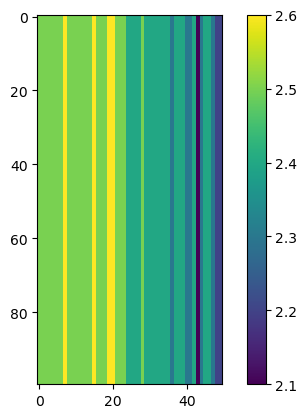

In [78]:
final_slope= np.zeros((slopes.shape[0], slopes.shape[1]))
final_slopes = np.round(slopes,2)
print(final_slopes)
plt.imshow(final_slopes)
plt.colorbar()

In [79]:
# calculate elasticity
def elasticity_HT (slope_value, density, conv_pix, conv_fr):
    conv_factor = (conv_pix / conv_fr)
    mu = ((slope_value * conv_factor)**2) * density
    return mu

In [80]:
# Compute elasticity
density = 1000
conv_pix = (1/1.286)*1e-6
conv_fr = (1/12500)/30 #(12500*85)/(85/10)

mu = elasticity_HT(final_slopes, density, conv_pix, conv_fr) 
mu_2dec = np.round(mu,2)


[[531.45 531.45 531.45 ... 449.82 411.55 411.55]
 [531.45 531.45 531.45 ... 449.82 411.55 411.55]
 [531.45 531.45 531.45 ... 449.82 411.55 411.55]
 ...
 [531.45 531.45 531.45 ... 449.82 411.55 411.55]
 [531.45 531.45 531.45 ... 449.82 411.55 411.55]
 [531.45 531.45 531.45 ... 449.82 411.55 411.55]]


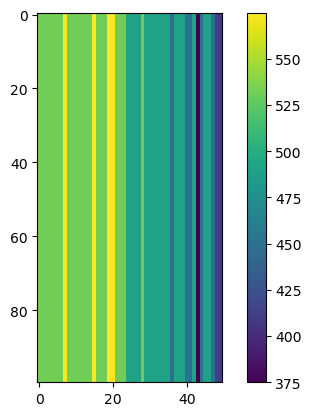

In [82]:
print(mu_2dec)
plt.imshow(mu_2dec)
plt.colorbar()
plt.savefig('comsol_G1100_mu.png')